In [1]:
!pip install kaggle
!pip install py7zr
!pip install dask
!pip install dask[dataframe]
!pip install pyunpack
!pip install patool
#os.system('apt-get install p7zip')
!pip install -U -q PyDrive
!pip install dask dask-ml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 2.5 MB/s eta 0:00:00a 0:00:01
INFO: pip is looking at multiple versions of distributed to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#from google.colab import files
import os
import py7zr
import os
import dask.dataframe as dd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
#from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.metrics import mean_squared_error
import numpy as np

In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/favorita-grocery-sales-forecasting/test.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/stores.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/train.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv.7z


In [4]:
import os
import zipfile
import py7zr
import dask.dataframe as dd

# Chemin vers le répertoire des fichiers téléchargés
input_dir = '/kaggle/input/favorita-grocery-sales-forecasting/'

# Chemin vers le répertoire où les fichiers seront extraits
output_dir = '/kaggle/working/'

# Fonction pour décompresser les fichiers .7z
def extract_7z_files(input_dir, output_dir):
    zip_files = [f for f in os.listdir(input_dir) if f.endswith('.7z')]
    if not zip_files:
        print("Aucun fichier .7z trouvé dans le répertoire.")
    else:
        for zip_file in zip_files:
            file_path = os.path.join(input_dir, zip_file)
            try:
                with py7zr.SevenZipFile(file_path, mode='r') as z:
                    z.extractall(path=output_dir)
            except Exception as e:
                print(f"Erreur lors de la décompression de {zip_file}: {e}")

# Fonction pour décompresser les fichiers .zip
def extract_zip_files(input_dir, output_dir):
    zip_files = [f for f in os.listdir(input_dir) if f.endswith('.zip')]
    if not zip_files:
        print("Aucun fichier .zip trouvé dans le répertoire.")
    else:
        for zip_file in zip_files:
            file_path = os.path.join(input_dir, zip_file)
            try:
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    zip_ref.extractall(output_dir)
            except Exception as e:
                print(f"Erreur lors de la décompression de {zip_file}: {e}")

# Extraction des fichiers
extract_7z_files(input_dir, output_dir)
extract_zip_files(input_dir, output_dir)

Aucun fichier .zip trouvé dans le répertoire.


In [5]:
# Vérifier les fichiers extraits
extracted_files = os.listdir(output_dir)
print(extracted_files)

# Lire les fichiers CSV avec Dask
csv_files = [f for f in extracted_files if f.endswith('.csv')]

data = {}
for csv_file in csv_files:
    file_path = os.path.join(output_dir, csv_file)
    try:
        df = dd.read_csv(file_path, assume_missing=True)
        data[csv_file.replace('.csv', '')] = df
    except Exception as e:
        print(f"Erreur lors de la lecture de {csv_file}: {e}")

# Afficher les données des fichiers CSV
for csv_file in csv_files:
    file_path = os.path.join(output_dir, csv_file)
    try:
        df = dd.read_csv(file_path, dtype={"onpromotion": "object"}, assume_missing=True)
        print(f"Contenu du fichier {csv_file}:")
        print(df.head())
    except Exception as e:
        print(f"Erreur lors de la lecture de {csv_file}: {e}")


['oil.csv', 'stores.csv', 'test.csv', 'transactions.csv', '.virtual_documents', 'sample_submission.csv', 'holidays_events.csv', 'items.csv', 'train.csv']
Contenu du fichier oil.csv:
         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20
Contenu du fichier stores.csv:
   store_nbr           city                           state type  cluster
0        1.0          Quito                       Pichincha    D     13.0
1        2.0          Quito                       Pichincha    D     13.0
2        3.0          Quito                       Pichincha    D      8.0
3        4.0          Quito                       Pichincha    D      9.0
4        5.0  Santo Domingo  Santo Domingo de los Tsachilas    D      4.0
Contenu du fichier test.csv:
            id        date  store_nbr  item_nbr onpromotion
0  125497040.0  2017-08-16        1.0   96995.0       False
1  125497041.0  2017-08-16        1.0 

/opt/conda/lib/python3.10/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/opt/conda/lib/python3.10/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/opt/conda/lib/python3.10/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


**Etape2: Préparation des données**

In [6]:
# Fusionner les DataFrames
train = data['train']
items = data['items']
stores = data['stores']
holidays_events = data['holidays_events']
transactions = data['transactions']
oil = data['oil']

# Fusionner les données de ventes avec les informations sur les articles et les magasins
train = train.merge(items, on='item_nbr', how='left')
train = train.merge(stores, on='store_nbr', how='left')

# Fusionner les données de ventes avec les informations sur les transactions
train = train.merge(transactions, on=['date', 'store_nbr'], how='left')

# Fusionner les données de ventes avec les informations sur les jours fériés et les événements
train = train.merge(holidays_events, on='date', how='left')

# Fusionner les données de ventes avec les informations sur le prix du pétrole
train = train.merge(oil, on='date', how='left')

# Afficher les premières lignes du DataFrame fusionné
print(train.head())


    id        date  store_nbr  item_nbr  unit_sales  onpromotion  \
0  0.0  2013-01-01       25.0  103665.0         7.0          NaN   
1  1.0  2013-01-01       25.0  105574.0         1.0          NaN   
2  2.0  2013-01-01       25.0  105575.0         2.0          NaN   
3  3.0  2013-01-01       25.0  108079.0         1.0          NaN   
4  4.0  2013-01-01       25.0  108701.0         1.0          NaN   

         family   class  perishable     city        state type_x  cluster  \
0  BREAD/BAKERY  2712.0         1.0  Salinas  Santa Elena      D      1.0   
1     GROCERY I  1045.0         0.0  Salinas  Santa Elena      D      1.0   
2     GROCERY I  1045.0         0.0  Salinas  Santa Elena      D      1.0   
3     GROCERY I  1030.0         0.0  Salinas  Santa Elena      D      1.0   
4          DELI  2644.0         1.0  Salinas  Santa Elena      D      1.0   

   transactions   type_y    locale locale_name         description  \
0         770.0  Holiday  National     Ecuador  Primer dia

In [7]:
# Assurez-vous que les données sont chargées dans 'data'
test = data['test']
items = data['items']
stores = data['stores']
holidays_events = data['holidays_events']
transactions = data['transactions']
oil = data['oil']

# Fusionner les données de test avec les informations sur les articles et les magasins
test = test.merge(items, on='item_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')

# Fusionner les données de test avec les informations sur les transactions
test = test.merge(transactions, on=['date', 'store_nbr'], how='left')

# Fusionner les données de test avec les informations sur les jours fériés et les événements
test = test.merge(holidays_events, on='date', how='left')

# Fusionner les données de test avec les informations sur le prix du pétrole
test = test.merge(oil, on='date', how='left')

# Afficher les premières lignes du DataFrame fusionné
print(test.head())


            id        date  store_nbr  item_nbr  onpromotion        family  \
0  125497040.0  2017-08-16        1.0   96995.0        False     GROCERY I   
1  125497041.0  2017-08-16        1.0   99197.0        False     GROCERY I   
2  125497042.0  2017-08-16        1.0  103501.0        False      CLEANING   
3  125497043.0  2017-08-16        1.0  103520.0        False     GROCERY I   
4  125497044.0  2017-08-16        1.0  103665.0        False  BREAD/BAKERY   

    class  perishable   city      state type_x  cluster  transactions type_y  \
0  1093.0         0.0  Quito  Pichincha      D     13.0           NaN    NaN   
1  1067.0         0.0  Quito  Pichincha      D     13.0           NaN    NaN   
2  3008.0         0.0  Quito  Pichincha      D     13.0           NaN    NaN   
3  1028.0         0.0  Quito  Pichincha      D     13.0           NaN    NaN   
4  2712.0         1.0  Quito  Pichincha      D     13.0           NaN    NaN   

  locale locale_name description transferred  dcoi

In [8]:
# Suppression des valeurs manquantes
train = train.dropna(subset=['onpromotion', 'dcoilwtico', 'transactions', 'transferred', 'locale_name', 'description', 'locale', 'type_y'])
test = test.dropna(subset=['onpromotion', 'dcoilwtico', 'transactions', 'transferred', 'locale_name', 'description', 'locale', 'type_y'])

In [9]:
# Calcul du nombre de NA par colonne
na_counts = train.isna().sum().compute()

# Affichage des résultats
print("Nombre de valeurs manquantes (NA) par colonne :")
print(na_counts)

# Calcul du nombre de NA par colonne
na_count = test.isna().sum().compute()

# Affichage des résultats
print("Nombre de valeurs manquantes (NA) par colonne :")
print(na_count)


Nombre de valeurs manquantes (NA) par colonne :
id              0
date            0
store_nbr       0
item_nbr        0
unit_sales      0
onpromotion     0
family          0
class           0
perishable      0
city            0
state           0
type_x          0
cluster         0
transactions    0
type_y          0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64
Nombre de valeurs manquantes (NA) par colonne :
id              0
date            0
store_nbr       0
item_nbr        0
onpromotion     0
family          0
class           0
perishable      0
city            0
state           0
type_x          0
cluster         0
transactions    0
type_y          0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64


/opt/conda/lib/python3.10/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


In [10]:
print(len(train))

print(len(test))


12560600
0


In [11]:
# Trier les données par date en ordre décroissant pour obtenir les observations les plus récentes en premier
train = train.sort_values(by='date', ascending=False)

# 4. Sélectionner les 5% les plus récentes
train_model = train.head(int(len(train) * 0.16))
train_model.info()

# Trier les données par date en ordre décroissant pour obtenir les observations les plus récentes en premier
test = test.sort_values(by='date', ascending=False)

# 4. Sélectionner les 5% les plus récentes
test_model = test.head(int(len(test) * 0.16))
test_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2009696 entries, 1499187 to 1374195
Data columns (total 20 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            float64
 1   date          object 
 2   store_nbr     float64
 3   item_nbr      float64
 4   unit_sales    float64
 5   onpromotion   float64
 6   family        object 
 7   class         float64
 8   perishable    float64
 9   city          object 
 10  state         object 
 11  type_x        object 
 12  cluster       float64
 13  transactions  float64
 14  type_y        object 
 15  locale        object 
 16  locale_name   object 
 17  description   object 
 18  transferred   object 
 19  dcoilwtico    float64
dtypes: float64(10), object(10)
memory usage: 322.0+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            0 non-null      float64
 1   date          

In [12]:
# Sauvegarder le DataFrame train_model sous forme de fichier CSV
train_model.to_csv('/kaggle/working/train_model.csv', index=False,mode='w')
print("Le fichier CSV a été sauvegardé dans l'environnement Kaggle.")

# Sauvegarder le DataFrame train_model sous forme de fichier CSV
test_model.to_csv('/kaggle/working/test_model.csv', index=False,mode='w')
print("Le fichier CSV a été sauvegardé dans l'environnement Kaggle.")


Le fichier CSV a été sauvegardé dans l'environnement Kaggle.
Le fichier CSV a été sauvegardé dans l'environnement Kaggle.


In [13]:
import dask.dataframe as dd

# Charger le fichier train_model.csv en utilisant Dask
train_model = dd.read_csv('/kaggle/working/train_model.csv')
test_model = dd.read_csv('/kaggle/working/test_model.csv')

# Fonction pour convertir la colonne 'date' en type datetime et extraire des fonctionnalités
def preprocess_date(df):
    df['date'] = dd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

# Exemple d'utilisation de la fonction preprocess_date
train_model = preprocess_date(train_model)
test_model = preprocess_date(test_model)

# Afficher les premières lignes du DataFrame après prétraitement
print(train_model.head())
print(test_model.head())

# Sauvegarder le DataFrame prétraité sous forme de fichier CSV
output_file = '/kaggle/working/train_model_preprocessed.csv'
train_model.compute().to_csv(output_file, index=False)
print(f"Le fichier prétraité a été sauvegardé sous {output_file}")

# Sauvegarder le DataFrame prétraité sous forme de fichier CSV
output_files = '/kaggle/working/test_model_preprocessed.csv'
train_model.compute().to_csv(output_files, index=False)
print(f"Le fichier prétraité a été sauvegardé sous {output_files}")

            id       date  store_nbr   item_nbr  unit_sales  onpromotion  \
0  125458564.0 2017-08-15       37.0  1037857.0         4.0          0.0   
1  125497024.0 2017-08-15       54.0  2081056.0         1.0          0.0   
2  125497035.0 2017-08-15       54.0  2089339.0         4.0          0.0   
3  125497034.0 2017-08-15       54.0  2089036.0         4.0          0.0   
4  125497033.0 2017-08-15       54.0  2088922.0         7.0          0.0   

           family   class  perishable       city  ...   type_y locale  \
0       BEVERAGES  1120.0         0.0     Cuenca  ...  Holiday  Local   
1  PREPARED FOODS  2986.0         1.0  El Carmen  ...  Holiday  Local   
2       GROCERY I  1006.0         0.0  El Carmen  ...  Holiday  Local   
3       GROCERY I  1034.0         0.0  El Carmen  ...  Holiday  Local   
4       GROCERY I  1076.0         0.0  El Carmen  ...  Holiday  Local   

   locale_name            description transferred dcoilwtico  year month  day  \
0     Riobamba  Fundaci

In [14]:
import pandas as pd

# Charger le fichier CSV contenant les données
df = pd.read_csv('/kaggle/working/train_model_preprocessed.csv')
df1=pd.read_csv('/kaggle/working/test_model_preprocessed.csv')
# Sélectionner les 5000 observations les plus récentes 
train_model_Final = df.head(5000) 
test_model_Final = df1.head(5000)
# Sauvegarder le sous-ensemble dans un nouveau fichier CSV
train_model_Final.to_csv('/kaggle/working/train_model_Final.csv', index=False)
test_model_Final.to_csv('/kaggle/working/test_model_Final.csv', index=False)

In [15]:
import pandas as pd
train_model_Final = pd.read_csv('/kaggle/working/train_model_Final.csv')
test_model_Final = pd.read_csv('/kaggle/working/test_model_Final.csv')

# Supprimer la colonne 'date' 'day','dayofweek'
train_model_Final = train_model_Final.drop(columns=['date','day','dayofweek'])
test_model_Final = test_model_Final.drop(columns=['date','day','dayofweek'])


# Sauvegarder le DataFrame train_model_preprocessed sous forme de fichier CSV, en remplaçant le fichier existant
train_model_Final.to_csv('/kaggle/working/train_model_Final.csv', index=False, mode='w')
print("Le fichier CSV a été sauvegardé dans l'environnement Kaggle.")

# Sauvegarder le DataFrame train_model_preprocessed sous forme de fichier CSV, en remplaçant le fichier existant
test_model_Final.to_csv('/kaggle/working/test_model_Final.csv', index=False, mode='w')

# Afficher les informations sur les données sélectionnées
train_model_Final.info()
test_model_Final.info()


Le fichier CSV a été sauvegardé dans l'environnement Kaggle.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            5000 non-null   float64
 1   store_nbr     5000 non-null   float64
 2   item_nbr      5000 non-null   float64
 3   unit_sales    5000 non-null   float64
 4   onpromotion   5000 non-null   float64
 5   family        5000 non-null   object 
 6   class         5000 non-null   float64
 7   perishable    5000 non-null   float64
 8   city          5000 non-null   object 
 9   state         5000 non-null   object 
 10  type_x        5000 non-null   object 
 11  cluster       5000 non-null   float64
 12  transactions  5000 non-null   float64
 13  type_y        5000 non-null   object 
 14  locale        5000 non-null   object 
 15  locale_name   5000 non-null   object 
 16  description   5000 non-null   object 
 17  transferre

# 1

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Charger le fichier train_model_preprocessed.csv
train_model_Final = pd.read_csv('/kaggle/working/train_model_Final.csv')

# Sélectionner les colonnes numériques à standardiser
numeric_columns = ['id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
                   'class', 'perishable', 'cluster', 'transactions', 'dcoilwtico', 'year', 'month']

# Initialiser le StandardScaler
std_scaler = StandardScaler()

# Standardiser les colonnes numériques
train_model_Final[numeric_columns] = std_scaler.fit_transform(train_model_Final[numeric_columns])

# Vérifier les types de colonnes après standardisation
print(train_model_Final.dtypes)

# Encodage one-hot des colonnes catégorielles
categorical_columns = ['family', 'city', 'state', 'type_x', 'type_y', 'locale', 'locale_name', 'description', 'transferred']
train_model_Final = pd.get_dummies(train_model_Final, columns=categorical_columns, drop_first=True)

# Afficher les premières lignes du DataFrame
print(train_model_Final.head())


id              float64
store_nbr       float64
item_nbr        float64
unit_sales      float64
onpromotion     float64
family           object
class           float64
perishable      float64
city             object
state            object
type_x           object
cluster         float64
transactions    float64
type_y           object
locale           object
locale_name      object
description      object
transferred        bool
dcoilwtico      float64
year            float64
month           float64
dtype: object
          id  store_nbr  item_nbr  unit_sales  onpromotion     class  \
0 -19.455666 -16.521779 -0.406940   -0.100864     -0.30908 -0.723888   
1   1.363438   1.168606  1.501401   -0.195625     -0.30908  0.811445   
2   1.369392   1.168606  1.516553   -0.100864     -0.30908 -0.817686   
3   1.368851   1.168606  1.515999   -0.100864     -0.30908 -0.794648   
4   1.368310   1.168606  1.515790   -0.006103     -0.30908 -0.760091   

   perishable   cluster  transactions  dcoilwtico

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Charger le fichier test_model_preprocessed.csv
test_model_Final = pd.read_csv('/kaggle/working/test_model_Final.csv')

# Sélectionner les colonnes numériques à standardiser
numeric_columns = ['id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
                   'class', 'perishable', 'cluster', 'transactions', 'dcoilwtico', 'year', 'month']

# Initialiser le StandardScaler
std_scaler = StandardScaler()

# Standardiser les colonnes numériques
test_model_Final[numeric_columns] = std_scaler.fit_transform(test_model_Final[numeric_columns])

# Vérifier les types de colonnes après standardisation
print(test_model_Final.dtypes)

# Encodage one-hot des colonnes catégorielles
categorical_columns = ['family', 'city', 'state', 'type_x', 'type_y', 'locale', 'locale_name', 'description', 'transferred']
test_model_Final = pd.get_dummies(test_model_Final, columns=categorical_columns, drop_first=True)

# Afficher les premières lignes du DataFrame
print(test_model_Final.head())


id              float64
store_nbr       float64
item_nbr        float64
unit_sales      float64
onpromotion     float64
family           object
class           float64
perishable      float64
city             object
state            object
type_x           object
cluster         float64
transactions    float64
type_y           object
locale           object
locale_name      object
description      object
transferred        bool
dcoilwtico      float64
year            float64
month           float64
dtype: object
          id  store_nbr  item_nbr  unit_sales  onpromotion     class  \
0 -19.455666 -16.521779 -0.406940   -0.100864     -0.30908 -0.723888   
1   1.363438   1.168606  1.501401   -0.195625     -0.30908  0.811445   
2   1.369392   1.168606  1.516553   -0.100864     -0.30908 -0.817686   
3   1.368851   1.168606  1.515999   -0.100864     -0.30908 -0.794648   
4   1.368310   1.168606  1.515790   -0.006103     -0.30908 -0.760091   

   perishable   cluster  transactions  dcoilwtico

In [18]:
#columns_to_drop = ['date']
#train_model_preprocessed = train_model_preprocessed.drop(columns=columns_to_drop)

print(train_model_Final.columns)
print(test_model_Final.columns)


Index(['id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'class',
       'perishable', 'cluster', 'transactions', 'dcoilwtico', 'year', 'month',
       'family_BEAUTY', 'family_BEVERAGES', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 'city_El Carmen',
       'city_Guayaquil', 'city_Manta', 'city_Quito', 'state_Guayas',
       'state_Manabi', 'state_Pichincha', 'type_x_C',

In [19]:
# Calculer la matrice de corrélation
correlation_matrix = train_model_Final.corr()

# Afficher la matrice de corrélation
print(correlation_matrix)


                                         id  store_nbr  item_nbr  unit_sales  \
id                                 1.000000   0.956776  0.125030    0.020059   
store_nbr                          0.956776   1.000000 -0.145045    0.010273   
item_nbr                           0.125030  -0.145045  1.000000    0.054779   
unit_sales                         0.020059   0.010273  0.054779    1.000000   
onpromotion                        0.087445   0.097100  0.014704    0.065342   
class                             -0.025827  -0.025903 -0.000219   -0.047308   
perishable                        -0.025453  -0.049414  0.056376    0.023492   
cluster                           -0.486937  -0.577534  0.079652   -0.053795   
transactions                      -0.684287  -0.749492  0.218544    0.017273   
dcoilwtico                              NaN        NaN       NaN         NaN   
year                                    NaN        NaN       NaN         NaN   
month                                   

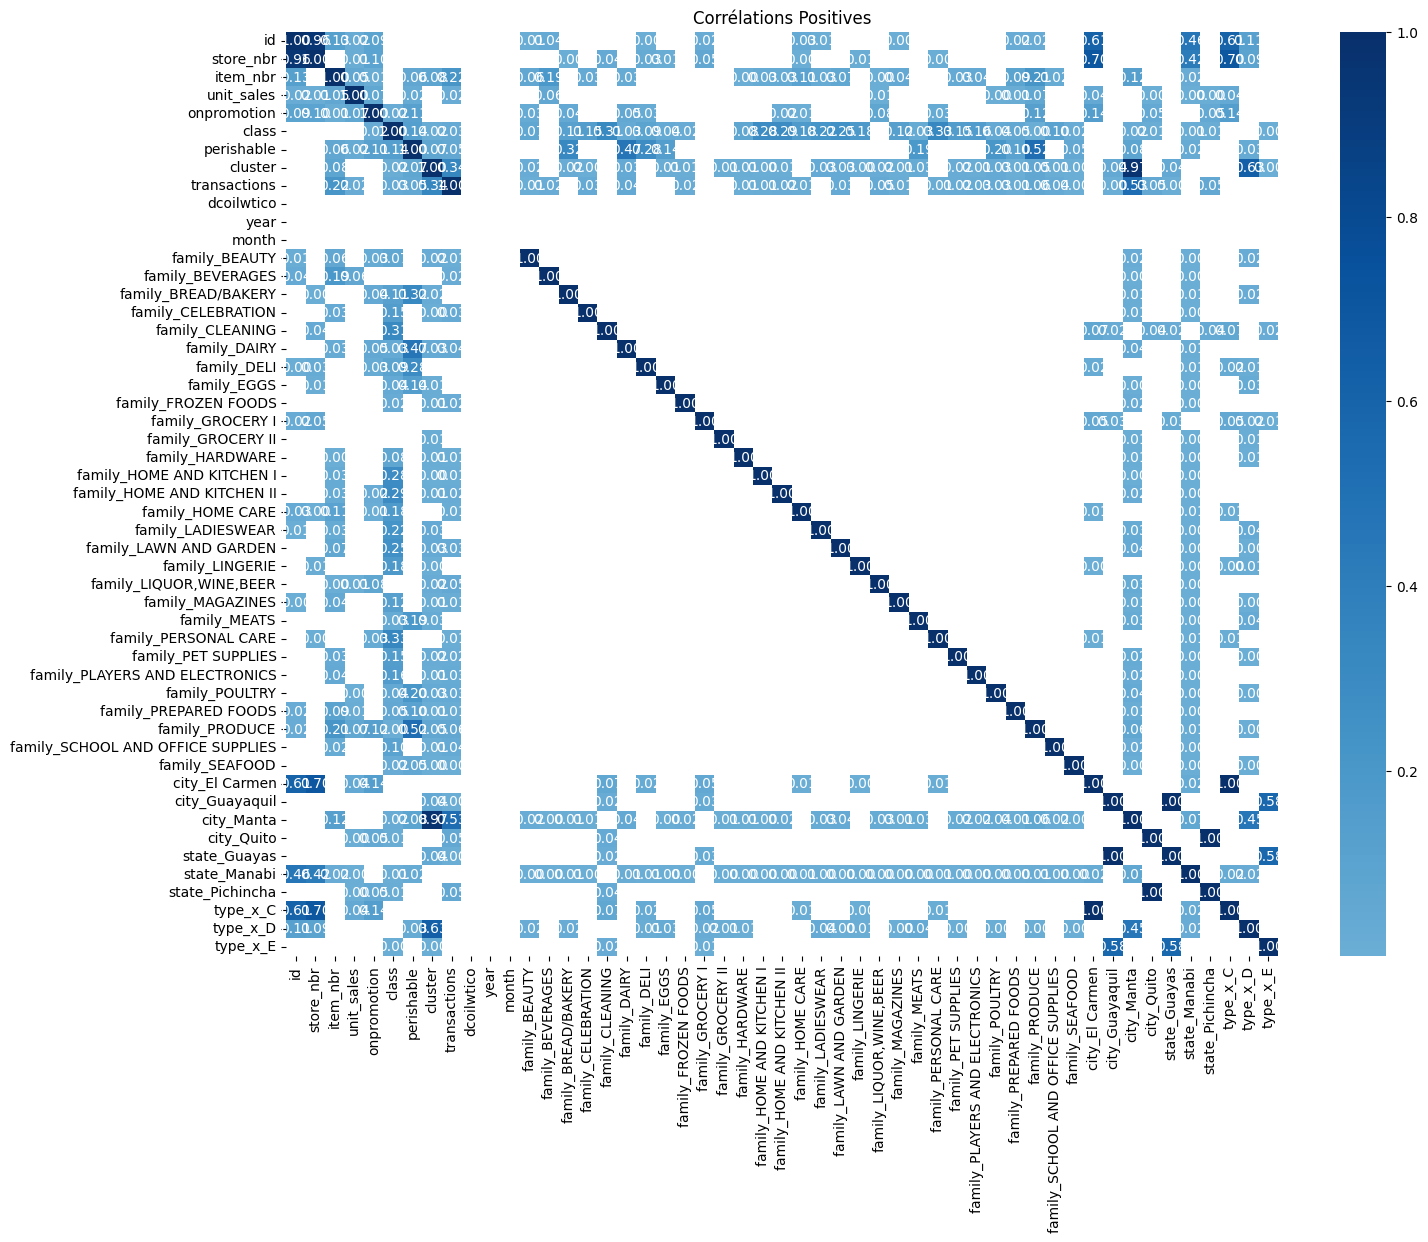

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

positive_correlations = correlation_matrix[correlation_matrix > 0]

# Heatmap des corrélations positives
plt.figure(figsize=(16, 12))
sns.heatmap(positive_correlations, annot=True, cmap='Blues', fmt='.2f', center=0)
plt.title('Corrélations Positives')
plt.show()

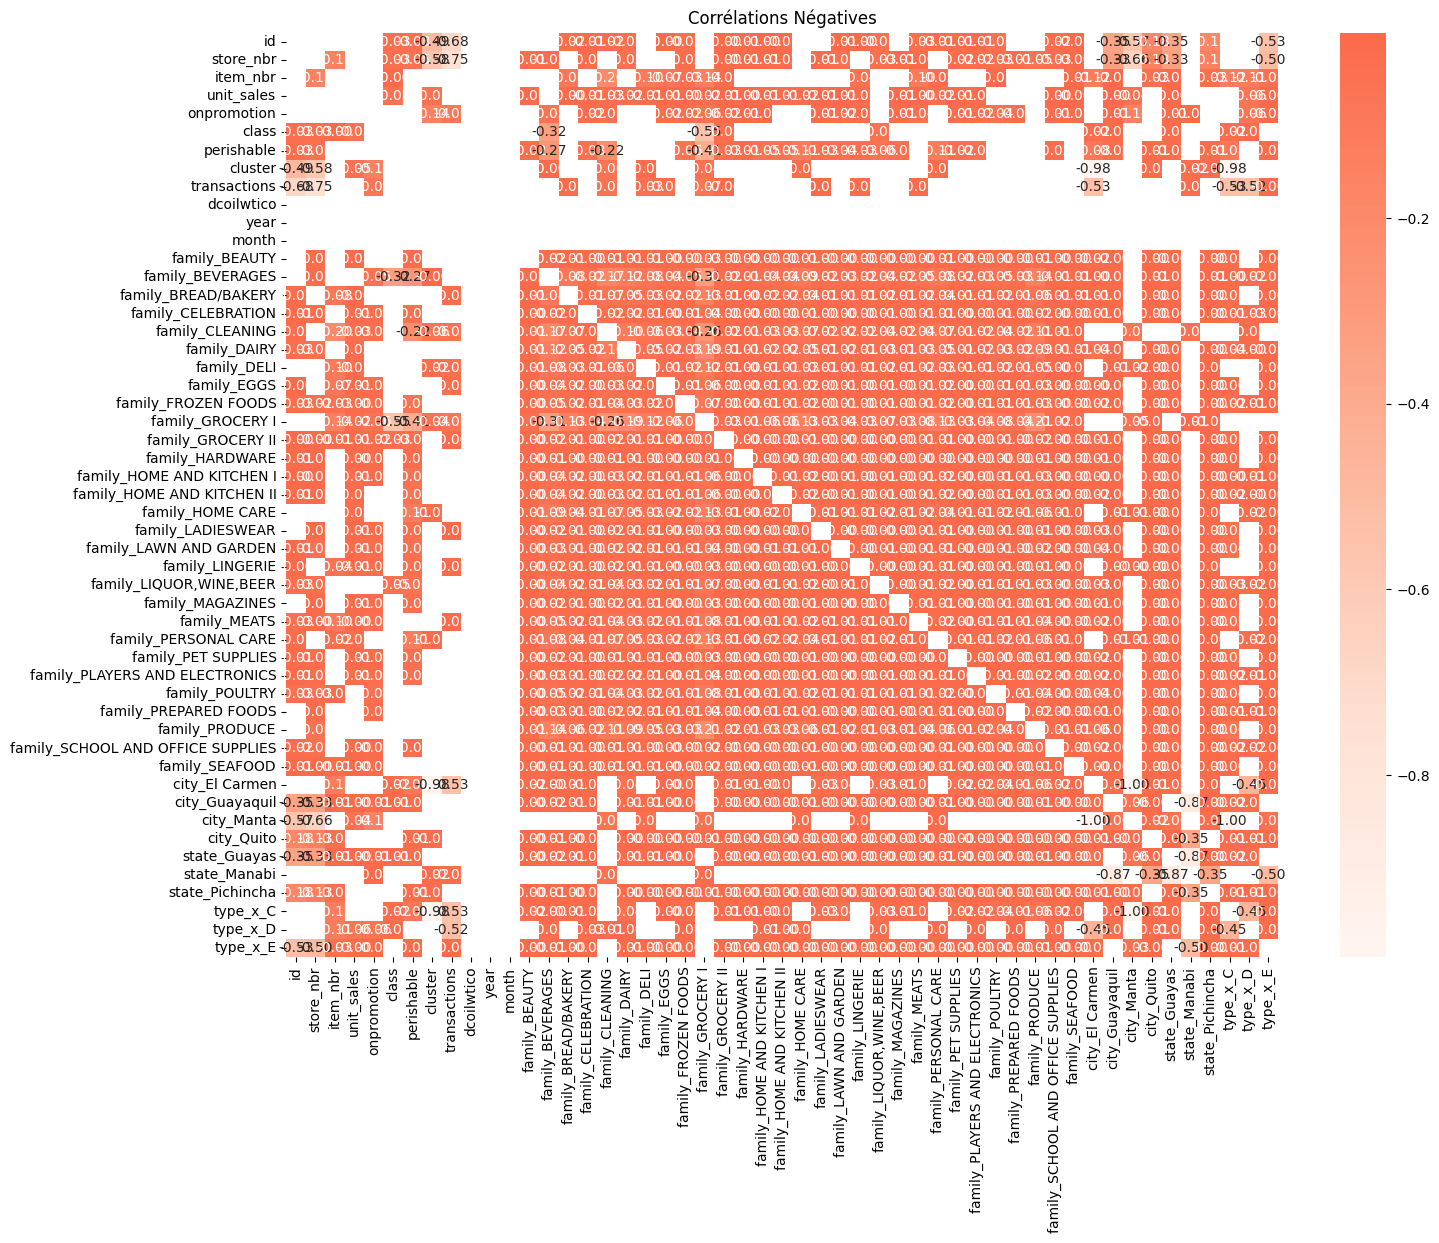

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

negative_correlations = correlation_matrix[correlation_matrix < 0]

# Heatmap des corrélations négatives
plt.figure(figsize=(16, 12))
sns.heatmap(negative_correlations, annot=True, cmap='Reds', fmt='.2f', center=0)
plt.title('Corrélations Négatives')
plt.show()


# TEST

In [22]:
# Calculer la matrice de corrélation
correlation_matrix1 = test_model_Final.corr()

# Afficher la matrice de corrélation
print(correlation_matrix1)


                                         id  store_nbr  item_nbr  unit_sales  \
id                                 1.000000   0.956776  0.125030    0.020059   
store_nbr                          0.956776   1.000000 -0.145045    0.010273   
item_nbr                           0.125030  -0.145045  1.000000    0.054779   
unit_sales                         0.020059   0.010273  0.054779    1.000000   
onpromotion                        0.087445   0.097100  0.014704    0.065342   
class                             -0.025827  -0.025903 -0.000219   -0.047308   
perishable                        -0.025453  -0.049414  0.056376    0.023492   
cluster                           -0.486937  -0.577534  0.079652   -0.053795   
transactions                      -0.684287  -0.749492  0.218544    0.017273   
dcoilwtico                              NaN        NaN       NaN         NaN   
year                                    NaN        NaN       NaN         NaN   
month                                   

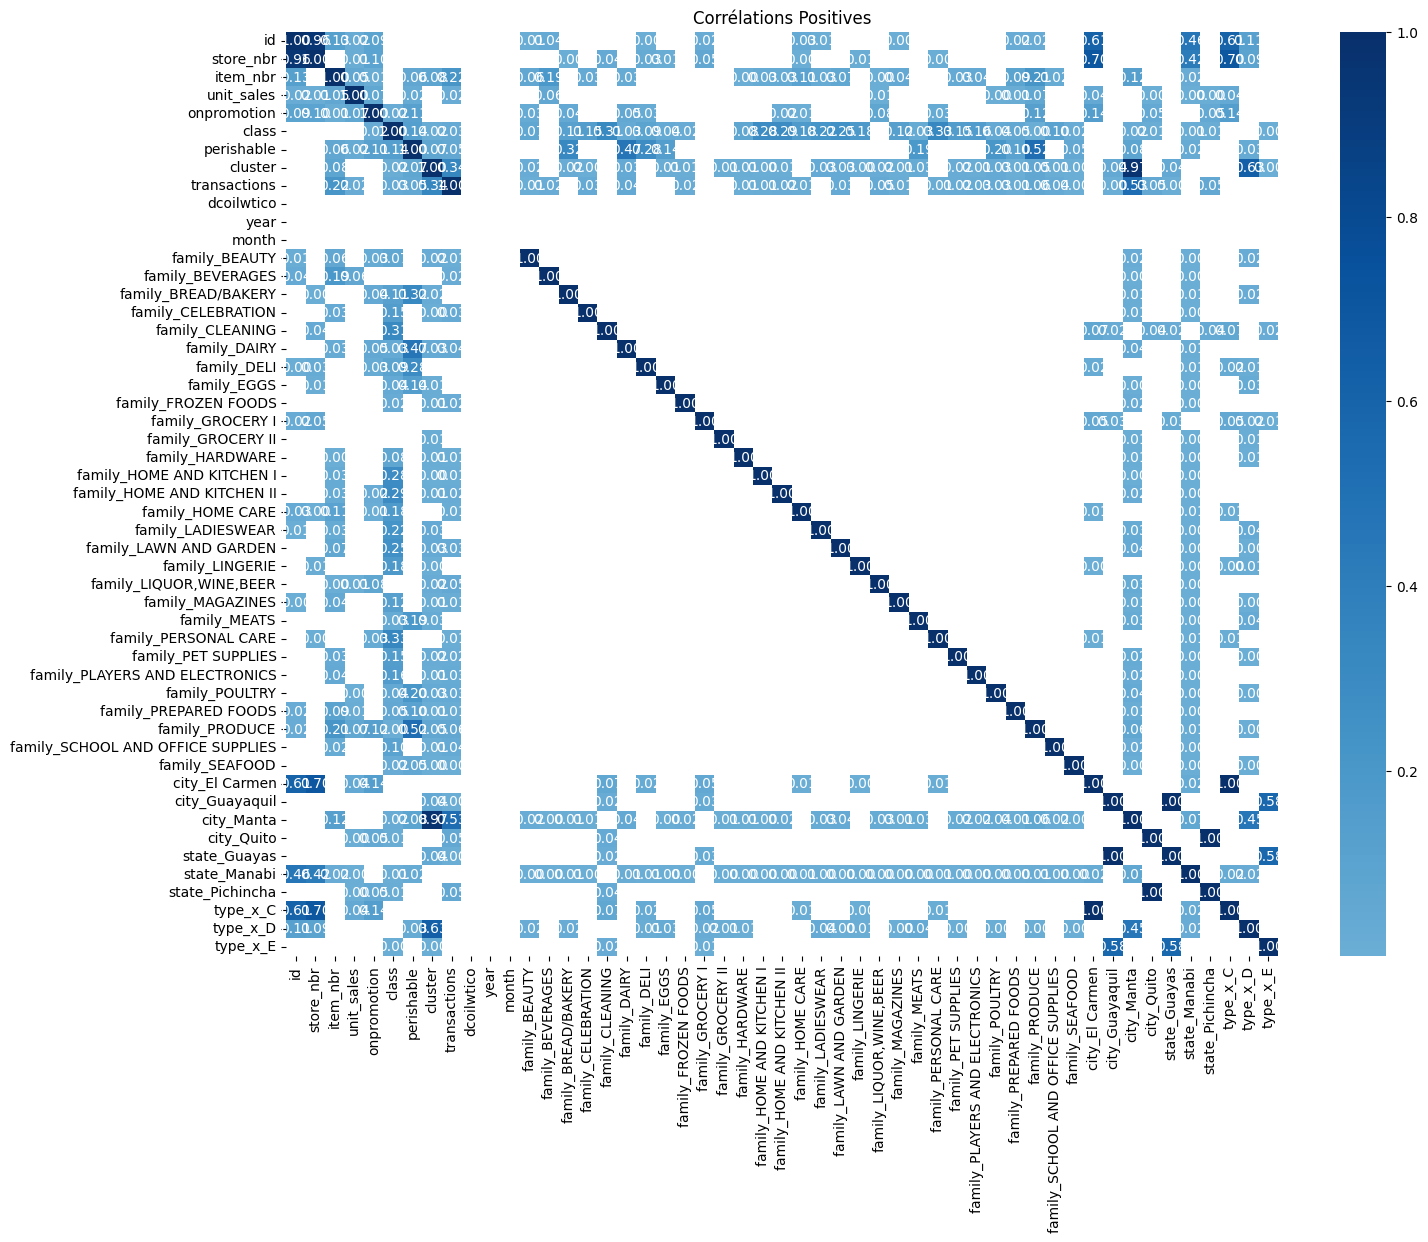

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

positive_correlations = correlation_matrix1[correlation_matrix1 > 0]

# Heatmap des corrélations positives
plt.figure(figsize=(16, 12))
sns.heatmap(positive_correlations, annot=True, cmap='Blues', fmt='.2f', center=0)
plt.title('Corrélations Positives')
plt.show()

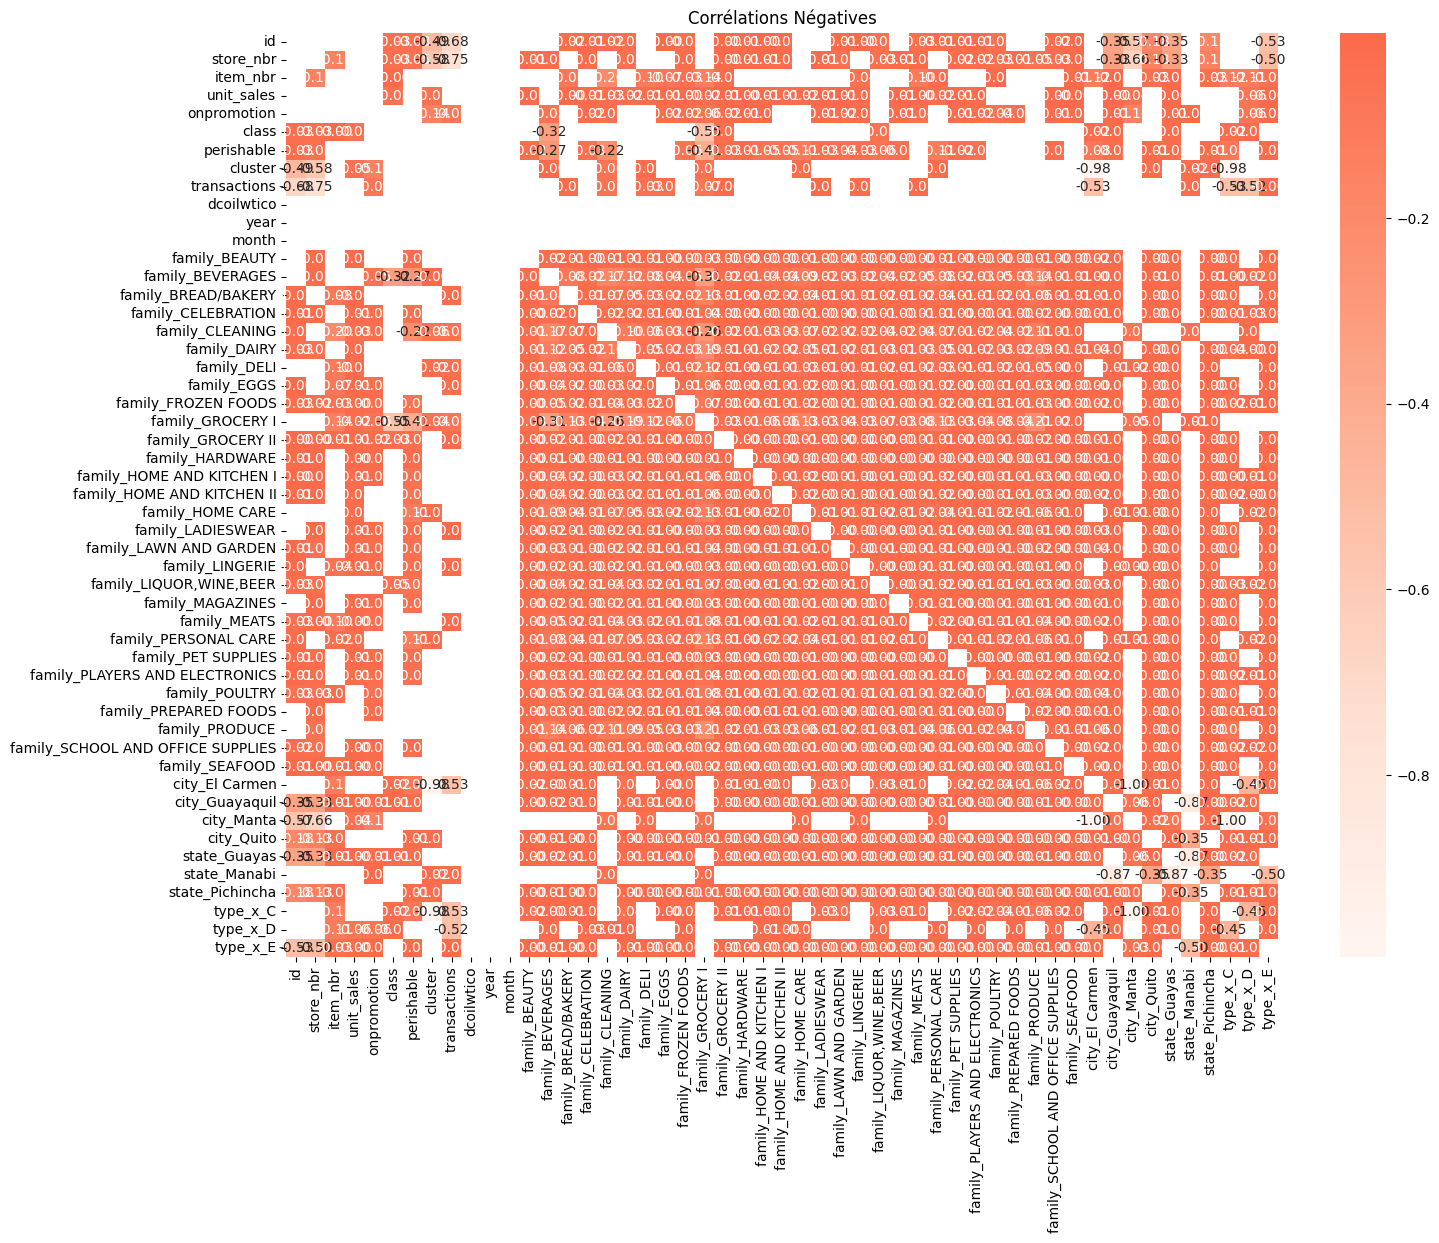

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

negative_correlations = correlation_matrix1[correlation_matrix1 < 0]

# Heatmap des corrélations négatives
plt.figure(figsize=(16, 12))
sns.heatmap(negative_correlations, annot=True, cmap='Reds', fmt='.2f', center=0)
plt.title('Corrélations Négatives')
plt.show()


# Choix des parametres

In [25]:
!pip install pmdarima
from pmdarima import auto_arima
import pandas as pd

# Charger les données
train_model_Final = pd.read_csv('/kaggle/working/train_model_Final.csv')

# Auto-ARIMA pour trouver les meilleurs paramètres
auto_model = auto_arima(train_model_Final['unit_sales'],
                        seasonal=True,  # Prendre en compte la saisonnalité
                        m=12,  # Saisonnalité hebdomadaire
                        trace=True,  # Afficher les essais de paramètres
                        stepwise=True,  # Méthode de recherche optimisée
                        suppress_warnings=True)

print(auto_model.summary())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.4 MB/s eta 0:00:0000:010:01
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=27.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=52043.164, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=50560.420, Time=1.52 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=10.64 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=52041.164, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=50558.454, Time=0.29 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=50560.419, Time=1.69 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=50562.419, Time=1.79 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=50059.435, Time=0.43 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=50061.419, Time=2.27 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=50061.419, Time=3.17 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=50063.419, Time=2.41 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=49779.895, Time=0.82 s

# Modele 1: SARIMAX

In [26]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Charger le fichier train_model_preprocessed.csv en utilisant Dask
train_model_preprocessed = pd.read_csv('/kaggle/working/train_model_Final.csv')

# Ajuster le modèle SARIMA
model = SARIMAX(train_model_preprocessed['unit_sales'], 
                order=(5, 1, 0),  # Paramètres ARIMA
                seasonal_order=(0, 0, 0, 12),  # Paramètres saisonniers (7 jours pour la saisonnalité hebdomadaire)
                enforce_stationarity=False,
                enforce_invertibility=False)
sarima_model = model.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.93998D+00    |proj g|=  8.39231D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   8.392D-06   4.940D+00
  F =   4.9399835187499184     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [27]:
# Afficher les résultats du modèle
print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:             unit_sales   No. Observations:                 5000
Model:               SARIMAX(5, 1, 0)   Log Likelihood              -24699.918
Date:                Thu, 19 Dec 2024   AIC                          49411.835
Time:                        06:46:04   BIC                          49450.931
Sample:                             0   HQIC                         49425.539
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8133      0.002   -506.295      0.000      -0.816      -0.810
ar.L2         -0.6156      0.002   -298.844      0.000      -0.620      -0.612
ar.L3         -0.4670      0.002   -198.477      0.0

In [29]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Prédire sur l'échantillon de test
predictions = sarima_model.predict(start=len(test_model_Final)-100,  # Exemple sur 100 derniers points
                                   end=len(test_model_Final)-1)

# Calculer le RMSE
rmse = np.sqrt(mean_squared_error(test_model_Final['unit_sales'][-100:], predictions))
print("RMSE:", rmse)


RMSE: 4.7622339275975465


In [37]:
from statsmodels.tsa.arima.model import ARIMA

# Ajuster le modèle ARIMA
model_arima = ARIMA(train_model_Final['unit_sales'], order=(1,1,0))
results_arima = model_arima.fit()
print(results_arima.summary())


                               SARIMAX Results                                
Dep. Variable:             unit_sales   No. Observations:                 5000
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -25276.227
Date:                Thu, 19 Dec 2024   AIC                          50556.454
Time:                        07:45:27   BIC                          50569.488
Sample:                             0   HQIC                         50561.022
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5072      0.001   -873.935      0.000      -0.508      -0.506
sigma2      1443.4275      1.168   1235.625      0.000    1441.138    1445.717
Ljung-Box (L1) (Q):                 122.83   Jarque-

In [36]:
from statsmodels.tsa.arima.model import ARIMA

# Ajuster le modèle ARIMA
model_arima = ARIMA(train_model_Final['unit_sales'], order=(5,1,1))
results_arima = model_arima.fit()
print(results_arima.summary())


                               SARIMAX Results                                
Dep. Variable:             unit_sales   No. Observations:                 5000
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -24347.419
Date:                Thu, 19 Dec 2024   AIC                          48708.837
Time:                        07:43:07   BIC                          48754.456
Sample:                             0   HQIC                         48724.826
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0174      0.008      2.135      0.033       0.001       0.033
ar.L2          0.0322      0.006      5.344      0.000       0.020       0.044
ar.L3         -0.0092      0.025     -0.368      0.7

**Avec Sarimax, les meilleurs paramettre pour avoir une bonne prédiction sont :(5,1,1)**

# Testons differents modèles:"Linear Regression","Ridge Regression","ElasticNet","Random Forest","XGBoost"

In [32]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Chargement des données
# Remplacez les chemins par ceux de vos fichiers
try:
    train_data = pd.read_csv('/kaggle/working/train_model_Final.csv')
    test_data = pd.read_csv('/kaggle/working/test_model_Final.csv')
    print("Données chargées avec succès !")
except FileNotFoundError as e:
    raise Exception(f"Erreur lors du chargement des fichiers : {e}")

# Préparation des colonnes nécessaires
required_features = ['store_nbr', 'item_nbr', 'onpromotion', 'family', 'class',
                     'perishable', 'city', 'state', 'type_x', 'cluster', 
                     'transactions', 'type_y', 'locale', 'dcoilwtico',
                     'year', 'month']
target = 'unit_sales'

# Vérification des colonnes dans les deux datasets
missing_features_train = list(set(required_features + [target]) - set(train_data.columns))
missing_features_test = list(set(required_features) - set(test_data.columns))

if missing_features_train:
    raise Exception(f"Les colonnes suivantes sont manquantes dans train.csv : {missing_features_train}")
if missing_features_test:
    raise Exception(f"Les colonnes suivantes sont manquantes dans test.csv : {missing_features_test}")

# Préparation des features (X) et des targets (y)
X_train = train_data[required_features]
y_train = train_data[target]

X_test = test_data[required_features]

# Encodage des variables catégoriques
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Aligner les colonnes des deux datasets après encodage
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Liste des modèles à tester
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "ElasticNet": ElasticNet(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Test des modèles
results = {}
best_model_name = None
best_model = None
best_rmse = float('inf')

for model_name, model in models.items():
    print(f"Entraînement du modèle {model_name}...")
    try:
        # Entraînement
        model.fit(X_train, y_train)
        # Validation croisée (calcul du RMSE sur les données d'entraînement)
        y_train_pred = model.predict(X_train)
        rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        results[model_name] = rmse
        
        # Identifier le meilleur modèle
        if rmse < best_rmse:
            best_rmse = rmse
            best_model_name = model_name
            best_model = model
    except Exception as e:
        print(f"Erreur lors de l'entraînement du modèle {model_name} : {e}")
        results[model_name] = "Erreur"

# Affichage des résultats
print("\nPerformances des modèles :")
for model_name, rmse in results.items():
    print(f"{model_name}: RMSE = {rmse:.2f}" if isinstance(rmse, float) else f"{model_name}: RMSE = {rmse}")

print(f"\nMeilleur modèle : {best_model_name} avec RMSE = {best_rmse:.2f}")

# Prédictions sur test.csv avec le meilleur modèle
if best_model:
    print("\nPrédiction sur le jeu de données test...")
    test_data['unit_sales_predicted'] = best_model.predict(X_test)
    # Sauvegarde des prédictions
    test_data[['id', 'unit_sales_predicted']].to_csv('/kaggle/working/test_predictions.csv', index=False)
    print("Prédictions sauvegardées dans 'test_predictions.csv'.")
else:
    print("Aucun modèle n'a été entraîné avec succès.")


Données chargées avec succès !
Entraînement du modèle Linear Regression...
Entraînement du modèle Ridge Regression...
Entraînement du modèle ElasticNet...
Entraînement du modèle Random Forest...
Entraînement du modèle XGBoost...

Performances des modèles :
Linear Regression: RMSE = 31.35
Ridge Regression: RMSE = 31.35
ElasticNet: RMSE = 31.51
Random Forest: RMSE = 14.67
XGBoost: RMSE = 7.41

Meilleur modèle : XGBoost avec RMSE = 7.41

Prédiction sur le jeu de données test...
Prédictions sauvegardées dans 'test_predictions.csv'.


# Exponential Smoothing

In [43]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Charger les données (remplacez le chemin par celui de votre fichier)
data = pd.read_csv('/kaggle/working/train_model_Final.csv')

# Assurez-vous que la colonne que vous utilisez est bien une série temporelle
data = data['unit_sales']  # Remplacez 'unit_sales' par le nom de votre colonne

# Vérifier s'il y a des valeurs manquantes et les gérer
if data.isnull().sum() > 0:
    data = data.fillna(method='ffill')  # Remplir les valeurs manquantes par la méthode forward fill

# Ajuster le modèle de lissage exponentiel
model_es = ExponentialSmoothing(data, seasonal='add', seasonal_periods=12)
results_es = model_es.fit()

# Afficher le résumé des résultats du modèle
print(results_es.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:               unit_sales   No. Observations:                 5000
Model:             ExponentialSmoothing   SSE                        5037351.490
Optimized:                         True   AIC                          34603.989
Trend:                             None   BIC                          34695.230
Seasonal:                      Additive   AICC                         34604.098
Seasonal Periods:                    12   Date:                 Thu, 19 Dec 2024
Box-Cox:                          False   Time:                         08:44:25
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0049611                alpha                 True
smoothing_seasonal       

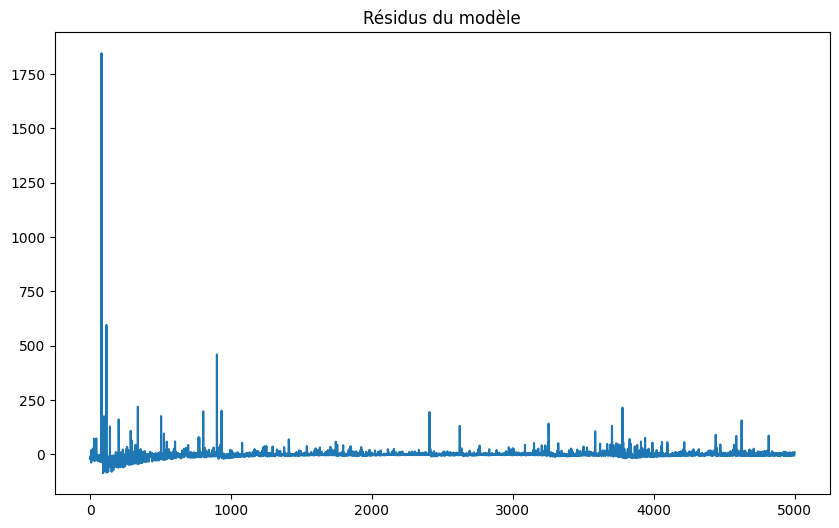

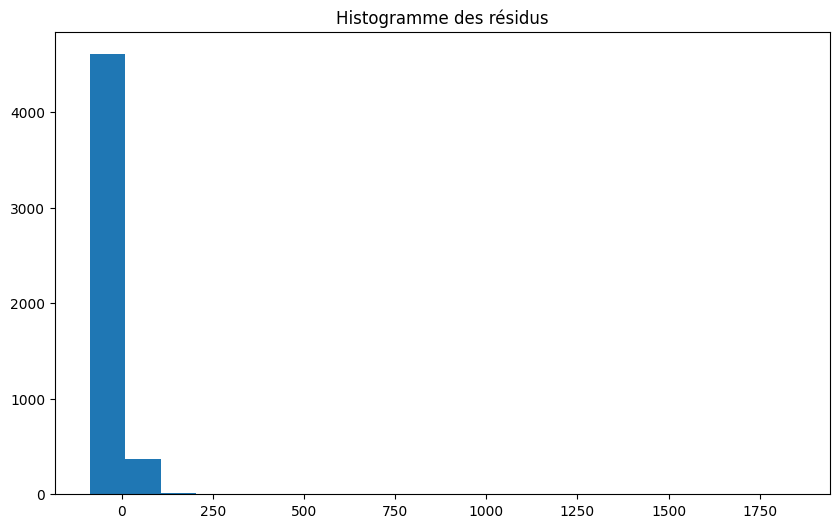

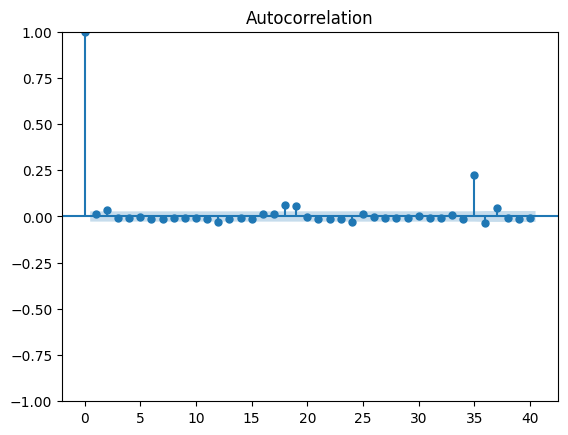

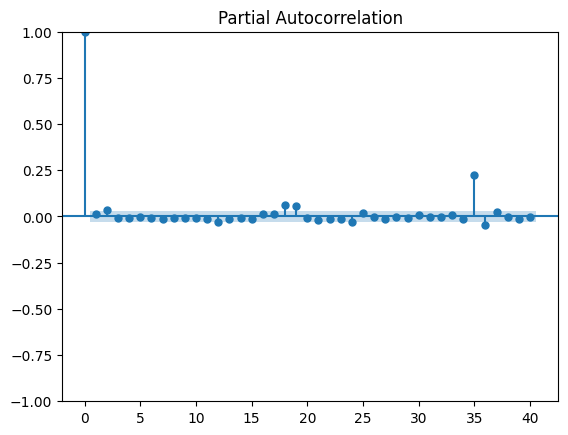

In [50]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Tracer les résidus
residuals = results_es.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Résidus du modèle')
plt.show()

# Histogramme des résidus
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20)
plt.title('Histogramme des résidus')
plt.show()

# Autocorrélation des résidus
sm.graphics.tsa.plot_acf(residuals, lags=40)
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()


In [45]:
from scipy.stats import shapiro

# Test de normalité des résidus
stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {p_value}")
if p_value > 0.05:
    print("Les résidus suivent une distribution normale.")
else:
    print("Les résidus ne suivent pas une distribution normale.")


Shapiro-Wilk p-value: 9.884796152600305e-92
Les résidus ne suivent pas une distribution normale.


In [46]:
from scipy import stats

# Transformation Box-Cox
train_model_Final['unit_sales_boxcox'], lambda_ = stats.boxcox(train_model_Final['unit_sales'] + 1)

# Modèle sur les données transformées
model_es_boxcox = ExponentialSmoothing(train_model_Final['unit_sales_boxcox'], seasonal='add', seasonal_periods=12)
results_es_boxcox = model_es_boxcox.fit()
print(results_es_boxcox.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:        unit_sales_boxcox   No. Observations:                 5000
Model:             ExponentialSmoothing   SSE                            454.712
Optimized:                         True   AIC                         -11959.643
Trend:                             None   BIC                         -11868.402
Seasonal:                      Additive   AICC                        -11959.534
Seasonal Periods:                    12   Date:                 Thu, 19 Dec 2024
Box-Cox:                          False   Time:                         08:52:38
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0285427                alpha                 True
smoothing_seasonal       

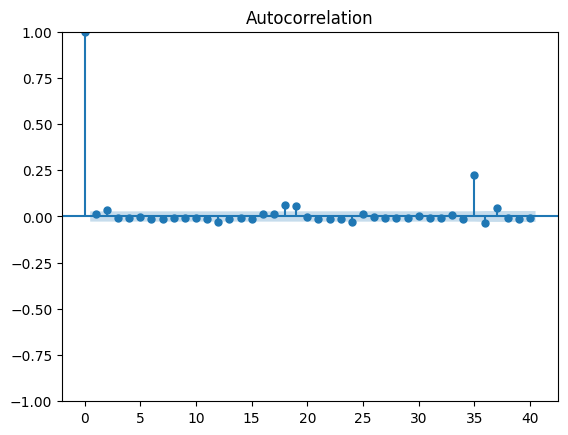

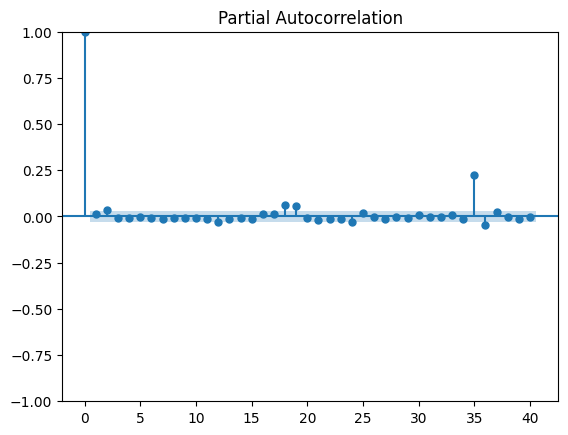

In [48]:
residuals = results_es.resid
sm.graphics.tsa.plot_acf(residuals, lags=40)
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()


In [49]:
forecast = results_es.forecast(steps=30)  # Par exemple, prévisions pour les 30 prochains jours
print(forecast)

5000    6.136968
5001    5.315821
5002    5.321207
5003    5.240700
5004    4.112897
5005    5.455876
5006    6.736238
5007    7.616098
5008    4.774464
5009    5.460437
5010    3.706097
5011    4.367098
5012    6.136968
5013    5.315821
5014    5.321207
5015    5.240700
5016    4.112897
5017    5.455876
5018    6.736238
5019    7.616098
5020    4.774464
5021    5.460437
5022    3.706097
5023    4.367098
5024    6.136968
5025    5.315821
5026    5.321207
5027    5.240700
5028    4.112897
5029    5.455876
dtype: float64
